In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from libs.tools import *
from libs.network import *
import torch
from geopy.distance import geodesic
from scipy import spatial
import copy

/home/ids/yukliu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading data

In [2]:
meta_data = pd.read_csv('./data/dichasus.csv')
# meta_data = pd.read_csv('./data/Opendata_3.csv')
csi_cols = [col for col in meta_data.columns if col not in ['Unnamed: 0', 'time', 'x', 'y']]
csi_data = meta_data[csi_cols].values
locations = meta_data[['x', 'y']].values

# Load Model

In [3]:
from copy import deepcopy

In [4]:
suffix = 'OpenDataTest_OfflineMining_42000'
suffix_distance = 'OpenDataTest_OfflineMining_Distance_HN_hidden4'
suffix_3 = 'OpenDataTest_OfflineMining_Distance_15'
# suffix_4 = 

################## Tripelts by distance
bs = 256
embed_dim_1 = 8
embed_dim_2 = 2

In [5]:
class ANN2(nn.Module):
    def __init__(self, in_feats, out_dim, hiddens=[64, 32]):
        super().__init__()
        self.name = "ANN"
        th.set_default_dtype(th.float32)
        assert len(hiddens) > 1
        list_FC_layers = [nn.Linear(in_feats, hiddens[0]), nn.ReLU()]
        n_hiddens = len(hiddens)
        for l in range(n_hiddens - 1):
            list_FC_layers.append(nn.Linear(hiddens[l], hiddens[l+1]))
            list_FC_layers.append(nn.ReLU())
            list_FC_layers.append(nn.BatchNorm1d(hiddens[l+1]))
        list_FC_layers.append(nn.Linear(hiddens[n_hiddens - 1], out_dim))
        # list_FC_layers.append(nn.BatchNorm1d(out_dim))
        self.model = nn.Sequential(*list_FC_layers)

    def forward(self, X):
        # return th.exp(self.model.forward(X))
        return self.model.forward(X.to(dtype=th.float32))
    
    def get_embedding(self, x):
        return self.forward(x)

In [6]:
dim_1 = 1024
dim_2 = 1053
# hiddens=[512, 256, 128, 64, 32, 16] # [512, 256, 128, 64]
hiddens = [512, 256, 128, 64]
# hiddens = [512, 256, 128, 64, 32, 16, 8, 4, 2]
hiddens_1 = [int(512 / (2 ** i)) for i in range(100) if 512 / (2 ** i) >= embed_dim_2]
hiddens_2 = [512, 256, 128, 64]
embedding_net = ANN2(dim_1, embed_dim_2, hiddens=hiddens_1)
embedding_net_2 = ANN2(dim_1, embed_dim_2, hiddens=hiddens_2)

triplet_net = TripletNet(embedding_net)
triplet_net_distance = TripletNet(embedding_net_2)

In [7]:
hiddens_3 = [int(512 / (2 ** i)) for i in range(100) if 512 / (2 ** i) >= 2]
triplet_net_3 = TripletNet(ANN(dim_1, embed_dim_1, hiddens=hiddens_1))

In [8]:
m = torch.load(f'/home/ids/yukliu/OpenTest/checkpoints/Triplet_emb_{embed_dim_2}_m_2_bs_{bs}_{suffix_distance}.sav')

In [89]:
triplet_net_distance.load_state_dict(torch.load(f'/home/ids/yukliu/OpenTest/checkpoints/Triplet_emb_{embed_dim_2}_m_2_bs_{bs}_{suffix_distance}.sav'))

<All keys matched successfully>

In [9]:
# triplet_net.load_state_dict(torch.load(f'/home/ids/yukliu/OpenTest/checkpoints/Triplet_emb_{embed_dim_1}_m_2_bs_{bs}_{suffix}.sav'))
triplet_net_distance.load_state_dict(torch.load(f'/home/ids/yukliu/OpenTest/checkpoints/Triplet_emb_{embed_dim_2}_m_2_bs_{bs}_{suffix_distance}.sav'))

<All keys matched successfully>

# Embedding Space

In [68]:
csi_tensor = torch.FloatTensor(csi_data)
cc = triplet_net.get_embedding(csi_tensor)
cc_arr = cc.detach().numpy()

In [91]:
cc_distance = triplet_net_distance.get_embedding(csi_tensor)
cc_arr_distance = cc_distance.detach().numpy()

In [31]:
cc_3 = triplet_net_3.get_embedding(csi_tensor).detach().numpy()

## Embedding distance vs Euclidean distance

In [10]:
from offline_mining_tools import *

In [11]:
def embedding_distance(cc_arr, locations, num=20000):
    d_ls = []
    c_ls = []
    for i in range(num):
        ids = np.random.choice(len(cc_arr), 2)
        c1, c2 = cc_arr[ids[0]], cc_arr[ids[1]]
        metric_d = np.linalg.norm(c1-c2)
        d = np.linalg.norm(locations[ids[0]]-locations[ids[1]])
        d_ls.append(d)
        c_ls.append(metric_d)
    return np.array(d_ls), np.array(c_ls)


def draw_ci_plot(d, c, ax=plt, label=None):
    bins, medians, perc_25, perc_75 = distance_ci_visualization(d, c)
    ax.plot(bins, medians, label=label)
    ax.fill_between(bins, perc_25, perc_75, alpha=0.5)
    ax.xlabel('Euclidean distance')
    ax.ylabel('Metric distance')
    ax.grid()

In [ ]:
d_time, c_time = embedding_distance(cc_arr, locations)
d_distance, c_distance = embedding_distance(cc_arr_distance, locations)
# d_3, c_3 = embedding_distance(cc_3, locations)

In [74]:
d_time

array([3.1329845 , 3.49819558, 6.91834496, ..., 2.15526996, 6.13976339,
       3.59036   ])

In [95]:
tmp = {'d': d_distance, 
       'c': c_distance}

In [100]:
np.save('./data/triplet_distance_dist', tmp, allow_pickle=True)

In [34]:
dict_metric = np.load('./data/metric_distance_dist.npy', allow_pickle=True).item()


In [35]:
def read_dict(dic, ax=plt, alpha=.5, label=None):
    bins = dic['bins']
    medians = dic['medians']
    p_25 = dic['25']
    p_75 = dic['75']
    ax.plot(bins, medians, label=label)
    ax.fill_between(bins, p_25, p_75, alpha=alpha)

In [30]:
dist_distance = np.load('./data/triplets_distance_distance_eval.npy', allow_pickle=True).item()
dist_time = np.load('./data/triplet_time_dist.npy', allow_pickle=True).item()

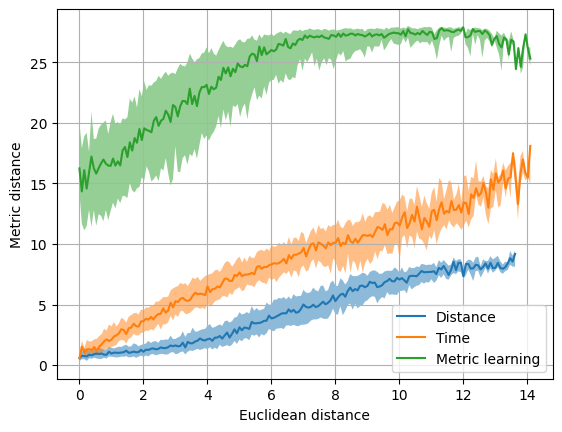

In [40]:
draw_ci_plot(dist_distance['d'], dist_distance['c'], label='Distance')
draw_ci_plot(dist_time['d'], dist_time['c'], label='Time')
read_dict(dict_metric, label='Metric learning')
plt.legend()
plt.grid()
plt.savefig('./result/distance_compare.pdf')

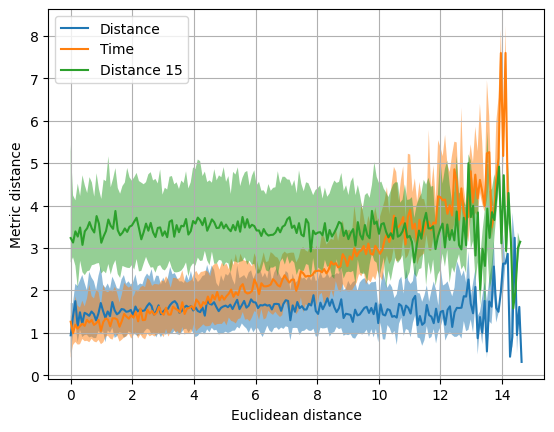

In [35]:
draw_ci_plot(d_distance, c_distance, label='Distance')
draw_ci_plot(d_time, c_time, label='Time')
draw_ci_plot(d_3, c_3, label='Distance 15')

plt.legend()

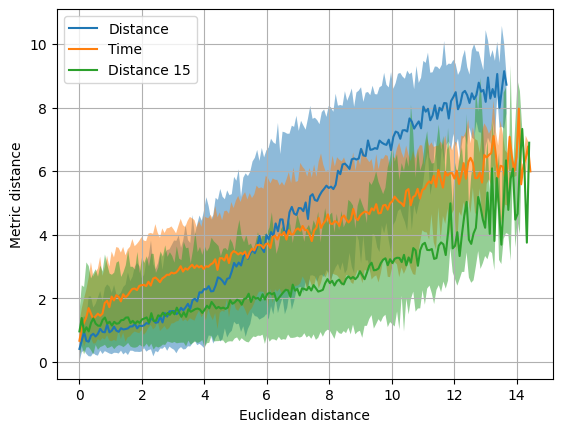

In [16]:
draw_ci_plot(d_distance, c_distance, label='Distance')
draw_ci_plot(d_time, c_time, label='Time')
draw_ci_plot(d_3, c_3, label='Distance 15')

plt.legend()

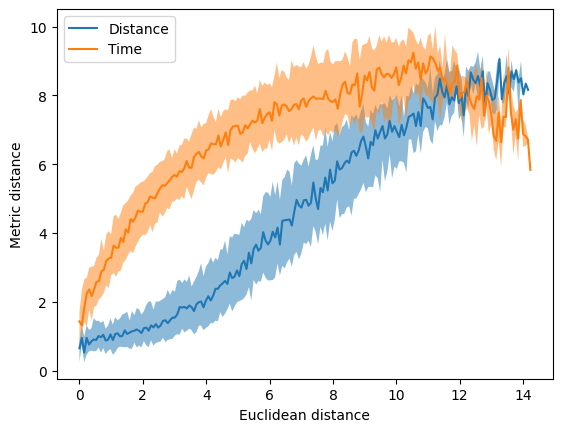

In [155]:
draw_ci_plot(d_distance, c_distance, label='Distance')
draw_ci_plot(d_time, c_time, label='Time')
plt.legend()

# Localization evaluation

In [204]:
def localisation_cc(cc, pos, n_neigh=5, geo=False):
    cc_train, cc_test, pos_train, pos_test = train_test_split(cc, pos, random_state=24)
    knr = KNeighborsRegressor(n_neighbors=n_neigh)
    knr.fit(cc_train, pos_train)

    pos_pred = knr.predict(cc_test)
    if geo:
        dist_err = dist_from_geo(pos_pred, pos_test)
    else:
        dist_err = np.linalg.norm(pos_pred - pos_test, axis=1)


    e_bar = np.quantile(dist_err, .9)
    anomlies = pos_test[dist_err>e_bar]
    return dist_err, pos_test

In [205]:
err_time, _ = localisation_cc(cc_arr, locations)
err_distance, _ = localisation_cc(cc_arr_distance, locations)

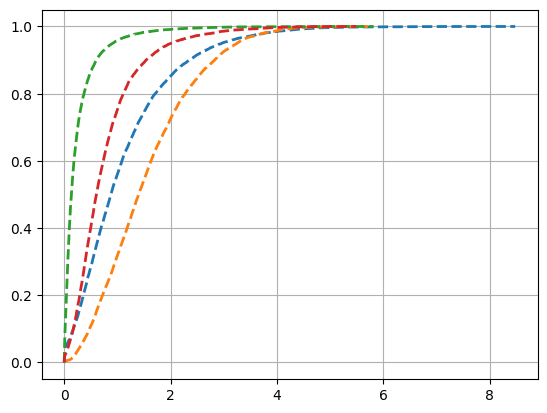

In [207]:
cdf_plot(err_time)
cdf_plot(err_distance)
cdf_plot(err_autogluon)
cdf_plot(err_bm)
plt.grid()

In [206]:
err = np.load('./data/dist_err_distance_opendata.npy')
err_autogluon = np.load('../data/dist_err_autogluon_OpenData_Autogluon.npy')
err_bm = np.load('./data/opendata_benchmark.npy')
err_metric = np.load('./data/dist_err_metric_learning.npy')

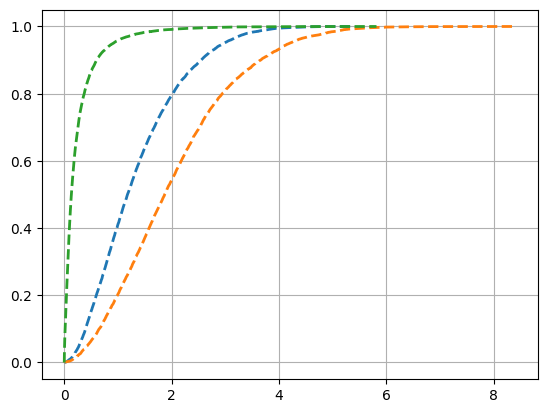

In [68]:
cdf_plot(err_time)
cdf_plot(err_distance)
cdf_plot(err_autogluon)
plt.grid()